# BDF Solver #

In [1]:
function BDFStart!(Y,T,h,k,BD,FD,ND,ID)
    A = ID - FD[k]*h*df(T[k],Y[k,:])
    B = (BD[k-1,1:k]'*Y[1:k,:]) - (FD[k]*h*f(T[k],Y[k,:]))'
    sol = \(A,B')
    err[k] = norm(sol)
    Y[k,:] = Y[k,:] - sol; 
end
function BDFGo!(Y,T,h,k,BD,FD,ND,ID,maxBDF)
    A = ID - FD[maxBDF]*h*df(T[k],Y[k,:])
    B = (BD[maxBDF,1:maxBDF+1]'*Y[k-maxBDF:k,:]) - (FD[maxBDF]*h*f(T[k],Y[k,:]))'
    sol = \(A,B')
    err[k] = norm(sol)
    Y[k,:] = Y[k,:] - sol;
end

BDFGo! (generic function with 1 method)

# BDF Stepper #

In [2]:
using LinearAlgebra
ND = [1 0 0 0 0 0; -1 2 0 0 0 0; 1 -3 3 0 0 0;-1 4 -6 4 0 0; -1 -1 8 -10 5 0; -1 4 -11 18 -15 6;] #Interpolation constants
 BD = [-1 1 0 0 0 0 0 ; 1/3 -4/3 1 0 0 0 0  ;-2/11 9/11 -18/11 1 0 0 0 ; #BDF constants
    3/25 -16/25 36/25 -48/25 1 0 0 ; -12/137 75/137 -200/137 300/137 -300/137 1 0 ;
    10/147 -72/147 225/147 -400/147 450/147 -360/147 1 ];
FD = [1 2/3 6/11 12/25 60/137 60/147];
function DoBDF!(Y,T,maxiter,maxBDF,h,tol,BD,FD,ND,ID)
    for  k =  2:maxBDF
        T[k] = T[k-1] + h; #Update step size
        err[k] = 1; # Reset error
        Y[k,:] = ND[k-1,1:k-1]'*Y[1:k-1,:] # Initial step guess using interpolation
        n = 0; # Initalize number of iterations
        while err[k] > tol
            n += 1
        BDFStart!(Y,T,h,k,BD,FD,ND,ID)
           if n == 20
                println("Is not converging")
                break
            end
        end
    end
    for k = maxBDF+1:maxiter
        T[k] = T[k-1]+h;
        err[k] = 1;
            Y[k,:] = ND[maxBDF,1:maxBDF]'*Y[k-maxBDF:k-1,:]
        n = 0;
        while err[k] > tol
            n += 1
                BDFGo!(Y,T,h,k,BD,FD,ND,ID,maxBDF)
                if n == 20
                println("Is not converging")
                break
        end
    end
    end
end

DoBDF! (generic function with 1 method)

## f(x) = x test ##

In [3]:
function f(t,x)
    [x[1];x[2]]
end
function df(t,x)
    [1 0; 0 1]
end
maxiter = 100; #maximum number of iterations
maxBDF = 6; # maximum order of BDF
(t0,y0) =(0, [1;1]); #Initial time and position
dim = length(y0) 
ID = Matrix(1.0I,length(y0),length(y0)); # Identity matrix
Y = Array{Float64}(undef, maxiter,dim)
T = Array{Float64}(undef, maxiter) 
err = Array{Float64}(undef,maxiter)
T[1]=t0;
Y[1,:]=y0;
h= .001; #Initial step size
tol = .0000001; #Tolerance
@time DoBDF!(Y,T,maxiter,maxBDF,h,tol,BD,FD,ND,ID)

  1.059200 seconds (4.34 M allocations: 243.409 MiB, 4.74% gc time, 99.98% compilation time)


# Rossler System #

  0.247862 seconds (748.17 k allocations: 53.274 MiB, 3.91% gc time, 99.89% compilation time)


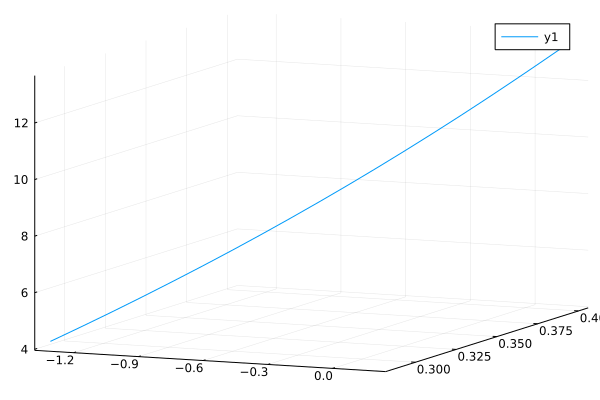

In [12]:
a= 0.2
b = 0.2
c = 5.7
function f(t,x)
    [(-x[2]-x[3]);(x[1] + a*x[2]); (b + x[3]*(x[1] - c))]
end
function df(t,x)
    [0 -1 -1;1 a 0; x[3] 0 x[1]-c]
end

tol = .0001
maxBDF = 6
maxiter =20
(t0,y0) =(0, [.2;.4;13.4]);
h = .01
dim = length(y0)
ID = Matrix(1.0I,length(y0),length(y0));
Y = Array{Float64}(undef, maxiter,dim)
T = Array{Float64}(undef, maxiter) 
T[1]=t0;
Y[1,:]=y0;
err = Array{Float64}(undef,maxiter)
@time DoBDF!(Y,T,maxiter,maxBDF,h,tol,BD,FD,ND,ID)
using Plots
plot3d(Y[:,1],Y[:,2],Y[:,3])

# AAS Piddling: Single Step

The general form of the order $s$ BDF is 
$$
\sum_{k=0}^s a_k y_{n+k} = h \beta f(t_k,y_k) 
$$
The specific formulae 
(from https://en.wikipedia.org/wiki/Backward_differentiation_formula) are 

* BDF1: $ y_{n+1}-y_{n}=hf(t_{n+1},y_{n+1}) $

* BDF2: $ y_{n+2}-{\tfrac {4}{3}}y_{n+1}+{\tfrac {1}{3}}y_{n}={\tfrac {2}{3}}hf(t_{n+2},y_{n+2})$

* BDF3: $ y_{n+3}-{\tfrac {18}{11}}y_{n+2}+{\tfrac {9}{11}}y_{n+1}-{\tfrac {2}{11}}y_{n}={\tfrac {6}{11}}hf(t_{n+3},y_{n+3})$

* BDF4: $ y_{n+4}-{\tfrac {48}{25}}y_{n+3}+{\tfrac {36}{25}}y_{n+2}-{\tfrac {16}{25}}y_{n+1}+{\tfrac {3}{25}}y_{n}={\tfrac {12}
{25}}hf(t_{n+4},y_{n+4})$

* BDF5: $ y_{n+5}-{\tfrac {300}{137}}y_{n+4}+{\tfrac {300}{137}}y_{n+3}-{\tfrac {200}{137}}y_{n+2}+{
\tfrac {75}{137}}y_{n+1}-{\tfrac {12}{137}}y_{n}={\tfrac {60}{137}}hf(t_{n+5},y_{n+5})$

* BDF6: $ y_{n+6}-{\tfrac {360}{147}}y_{n+5}+{\tfrac {450}{147}}y_{n+4}-{\tfrac {400}{147}}y_{n+3}+{\tfrac {225}{147}}y_{n+2}-{
\tfrac {72}{147}}y_{n+1}+{\tfrac {10}{147}}y_{n}={\tfrac {60}{147}}hf(t_{n+6},y_{n+6})$

The $\beta$ coefficients are stored as a the vector 
$$
\beta = [1, 2/3, 6/11, 12/25, 60/137, 60/147]
$$
We rewrite the general formula (since $a_0=1$ for all $s$) to the update form 
$$
y_k = h \beta f(t_k,y_k) - \sum_{i=1}^s a_i(s) y_{k-i} = h \beta f(t_k,y_k) + \alpha(s) \cdot y[k-s:k-1]
$$
where $\alpha(s)$ is a vector of length $s$ storing {\em memory} coefficients for the scheme. The 6 different 
coefficients are defined in a Dictionary structure.

Defining 
$$
\phi(x) = x - h \beta f(t_k,x) + \sum_{i=1}^p \alpha_i y_{k-i}
$$
we see that the standard Newtons iteration is 
$$
x_{n+1} =  x_n - J(x_n)^{-1} \phi(x_n) 
$$
where the Jacobian $J$ is defined from $F$ the gradient of $f$ by   
$$
J(x) = I - h \beta F(t_k,x).  
$$
The Newton iteration is run until the residual vector $\phi(x_n)$ is less than a pre-specified 
tolerance. It can be initialized using a variety of predictors.

The most boring predictor is simply $y_{k-1}$.  I am doing this for right now.  

In [46]:
using LinearAlgebra

function BDFStep!(Y,T,f,df,h,k,s)
    # Fills predefined solution array Y and vector T with the kth entry using the 
    # using the order "s" BDF with step h see
    # https://en.wikipedia.org/wiki/Backward_differentiation_formula of order "p"
    # f and df are out of place evaluations for the function y'=f(t,y) and derivative df
    # Skeleton yNew = FD h f(tNew, yNew)- BD.yOld 
    # BDF Last constants
    Betas = [1 2/3 6/11 12/25 60/137 60/147]; 
    # BDF First constants  AAS edited to dictionary and dropped the "1" and flipped signs 
    alphaDict = Dict(
        1=>[1],
        2=>[-1/3; 4/3],
        3=>[2/11; -9/11; 18/11],
        4=>[-3/25; 16/25; -36/25; 48/25],
        5=>[12/137; -75/137; 200/137; -300/137; 300/137],
        6=>[-10/147; 72/147; -225/147; 400/147; -450/147; 360/147]
    )
    # Implement Newtons Method.  Approximate solution is "x"
    # Extracts parameters 
    hBeta = h*Betas[s]; Alpha =  alphaDict[s];
    # Precomputes static history term and sets t for clarity
    history = Y[:,k-s:k-1]*Alpha;
    t=T[k];
    # Runs untill the residual is small. Simple initialization. 
    MaxNewtonSteps=12; i=0;
    x = Y[:,k-1];  RHS = x - hBeta*f(t,x) + history;
    while (i=i+1)< MaxNewtonSteps
        # Builds appropriate Jacobian J
        J = I - hBeta*df(t,x);
        # Solve for the next Newton Step 
        x = x - J\RHS;
        # Updates RHS vector 
        RHS = x - hBeta*f(t,x) + history;
        println(i, ": ", x)
    end
    # save output to Y and T
    T[k]=T[k-1]+h;
    Y[:,k] = x 
end

BDFStep! (generic function with 1 method)

In [47]:
# Define Rossler system
(a, b, c) = (0.2, 0.2, 5.7)
function ross(t,x)
    [-x[2]-x[3]; x[1] + a*x[2] ; b + x[3]*(x[1] - c)]
end
function dross(t,x)
    [0 -1 -1; 1 a 0;  x[3] 0 x[1]-c]
end

# Initialize storage and Initial Conditions
(dim,MaxIter) = (3,12);
Y = Array{Float64}(undef, dim, MaxIter); T = Array{Float64}(undef, MaxIter) 
h = 0.01; T[1]=0.0; Y[:,1]= [0.2 0.4 13.4];
(k,s)=(2, 1)
BDFStep!(Y,T,ross,dross,h,k,s);
Y

1: [-0.06864862273755262, -0.4014894651576909, -12.73364826108705]
2: [-0.06931314158998839, -0.40149612366322635, -12.667189717337934]
3: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
4: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
5: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
6: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
7: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
8: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
9: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
10: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]
11: [-0.06931313740999775, -0.4014961236213427, -12.667190135378883]


3×12 Matrix{Float64}:
  0.2   -0.0693131  8.91681e-315  …  8.89642e-315  0.0  0.0  0.0
  0.4   -0.401496   1.33962e-315     8.89642e-315  0.0  0.0  0.0
 13.4  -12.6672     1.33965e-315     8.89642e-315  0.0  0.0  0.0

In [71]:
history

3-element Vector{Float64}:
 -0.0002
 -0.0004
 -0.0134

In [72]:
RHS

3-element Vector{Float64}:
 -0.013800000000000002
  0.00028000000000000003
 -0.0717

In [69]:
 y0=[0.2 ;0.4; 13.4]

3-element Vector{Float64}:
  0.2
  0.4
 13.4